<h2> Find S1 and S2 for line sources in Run03 WS data to constrain g1&g2 with Doke method </h2>

In [1]:
import sys
home_dir=!echo "$HOME"
sys.path.insert(2,home_dir[0]+'/iPyNb/NERSC_Import') 
from pyROOT_import import *

from mpl_numpy_scipy_import import *
from aLib_import import *
%pylab inline  
#always do this for plotting in notebook... 
#now set the size of figures to display in window
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # set size of figures

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


<h1> Define 2D Normal fitting  </h1>

In [2]:
import scipy.optimize as opt
import numpy as np

def twoD_Gaussian((x, y), amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

<h1> Load in all the LUX Run03 WIMP Search Data </h1>

In [7]:
chain = TChain('golden')
chain.Add('/project/projectdirs/lux/data/golden/root/Golden_Run03/Golden_150303_WS*.root')
# add the Cs data
chain2 = TChain('golden')
chain2.Add('/project/projectdirs/lux/data/golden/root/Cs_Run03/Golden_Cs137_Aug.root')

1

<h1> Define the S1 and S2 cuts to seperate the islands of energy (see later plots) </h1>

In [31]:
Energies=[5.2,41.55,163.9,207,236.8,410,609,661.6]
#NamesE=["5keV","83Kr-42","164","207","237","410","609","662"]
NamesE=["#splitline{x-ray}{5.3 keV}","#splitline{\r ^{83m}Kr}{42 keV}","#splitline{\r ^{131m}Xe}{164 keV}",\
       "#splitline{\r ^{127}Xe}{208 keV}","#splitline{\r ^{127}Xe, \r ^{129m}Xe}{236 keV}",\
        "#splitline{\r ^{127}Xe}{409keV}","#splitline{\r ^{214}Bi}{609 keV}","#splitline{\r ^{137}Cs}{662 keV}"]

cutsx=[[log10(1400),log10(1400),log10(2600),log10(2600)],
           [3.6,3.6,4.4,4.4],
           [4.6,4.6,4.9,4.9], 
           [4.7,4.7,4.95,4.95], 
           [4.7,4.7,5.05,5.05], 
           [5.02,5.02,5.3,5.25], 
           [5.3,5.3,5.5,5.5],
           [5.55,5.35,5.4,5.6]]

cutsy=[[1,log10(40),log10(40),1],
           [2.2,2.6,2.6,2.2],
           [2.9,3.1,2.9,2.8], 
           [3.05,3.15,3.0,2.9], 
           [3.1,3.25,3.1,2.95], 
           [3.35, 3.5, 3.3, 3.2], 
           [3.4,3.63,3.43,3.25],
           [3.25,3.5,3.6,3.4]]

mean_s2=zeros(len(Energies))
mean_s2_sig=zeros(len(Energies))
mean_s1=zeros(len(Energies))
mean_s1_sig=zeros(len(Energies))

<h3> Analysis for the 5.2 keV line. Extending radius to 22 cm </h3>

In [5]:
c3 = rootnotes.default_canvas()

In [6]:
fid_vol=TCut('drift>38 && drift<305 && correctedRadius<23.5')
area_cut=TCut('s1area>0 && s1area<10**4 && s2area_raw>150 && s2area>50 && s2area<10**6')
bad_area_cut=TCut('((goodArea<=630 && badArea < 80) || (goodArea>630 && badArea < 80+0.095*(goodArea-630)))')

In [9]:
chain.SetMarkerStyle(7)
chain.SetMarkerSize(10)
density_plt_hst=TH2F('density_plt_hst','5.2 keV x-ray 1;S2_{c};spikyS1_{c}',20,500,3500,20,1,50)
#density_plt_hst.Draw()
chain.Draw('s1area:s2area>>density_plt_hst',fid_vol+area_cut+bad_area_cut,'colz') #s1area, s1spiky

TROOT::Append:0: RuntimeWarning: Replacing existing TH1: density_plt_hst (Potential memory leak).


2957759L

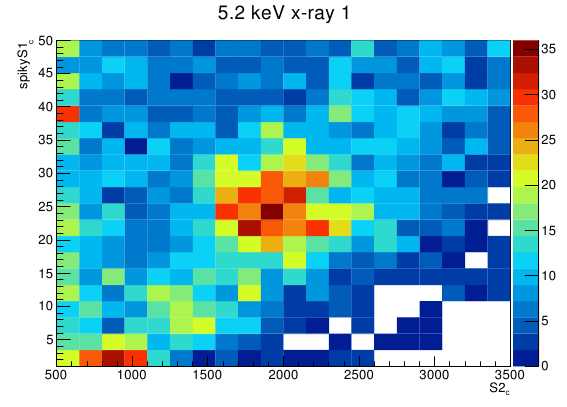

In [10]:
c3.SetLogz(0)
gStyle.SetOptStat(0)
gStyle.SetPalette(55)
gStyle.SetNumberContours(100)
#c3.SaveAs('Run03_Golden_Doke/5keV.pdf')
c3

In [11]:
E_cut=TCut('(s1area>10 && s1area<40 && s2area>1400 && s2area<2600)') #s1area #spikyS1
#E_cut2.SetVarX('s2area')
#E_cut2.SetVarY('s1area')

In [12]:
density_plt_hst=TH2F(NamesE[0],NamesE[0]+';S2_{c};S1_{c}',20,1000,3500,20,10,50)
combined_cut=TCut(E_cut.GetTitle() + '&&'+ fid_vol.GetTitle() + '&&'+ area_cut.GetTitle() + '&&' + bad_area_cut.GetTitle())
n=chain.Draw('s1area:s2area>>'+NamesE[0],combined_cut,'colz') #s1area

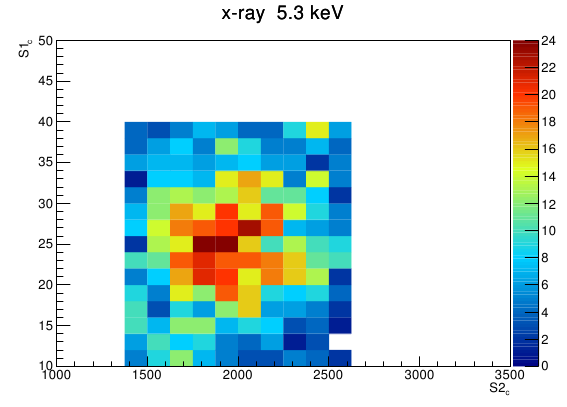

In [13]:
c3

<h1> grab root data and convert to numpy array for 2D Gaussian fitting </h1>

In [207]:
s1 = ndarray( (n,),dtype= float64, buffer=chain.GetV1())
s2 = ndarray( (n,),dtype= float64, buffer=chain.GetV2())

In [208]:
H, xedges, yedges = histogram2d(s2, s1, bins=10, range=None, normed=False)
H=H.T
x_bin_center=(xedges[:-1]+xedges[1:])/2
y_bin_center=(yedges[:-1]+yedges[1:])/2

In [209]:
#plt.contourf(x_bin_center,y_bin_center,H,25)
#plt.colorbar()

In [210]:
initial_guess = (H.max(), mean(s2), mean(s1), std(s2), std(s1),0,0)
x, y = np.meshgrid(x_bin_center, y_bin_center)

popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), H.ravel(), p0=initial_guess)

mean_s2[0]=popt[1]
mean_s2_sig[0]=sqrt(pcov[1,1])
mean_s1[0]=popt[2]
mean_s1_sig[0]=sqrt(pcov[2,2])

In [211]:
savetxt('Run03_Golden_Doke/fits/5keVfit.txt', popt, fmt='%.18e', delimiter=' ', newline='\n', header='', footer='', comments='# ')
savetxt('Run03_Golden_Doke/fits/5keVcov.txt', pcov, fmt='%.18e', delimiter=' ', newline='\n', header='', footer='', comments='# ')

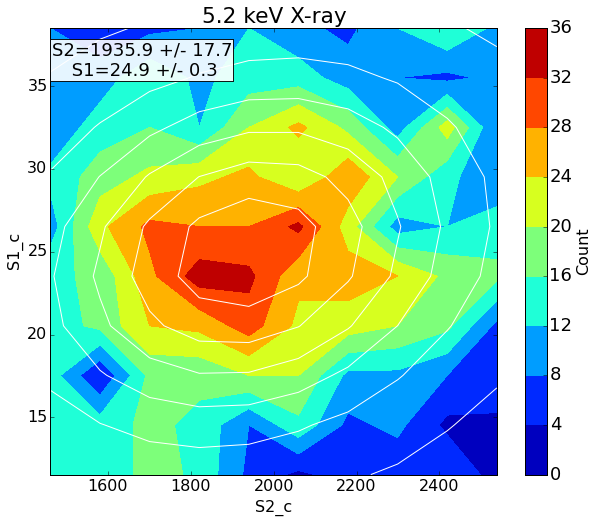

In [212]:
data_fitted = twoD_Gaussian((x, y), *popt)
figure
fig, ax = plt.subplots(1,1)
ax.hold(True)
#ax.imshow(H.reshape(x.shape), cmap=plt.cm.jet, origin='bottom',
#    extent=(x.min(), x.max(), y.min(), y.max()))
plt.contourf(x_bin_center,y_bin_center,H,10)
ax.contour(x, y, data_fitted.reshape(x.shape), 7, colors='w')
plt.xlabel('S2_c',fontsize=16)
plt.ylabel('S1_c',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
cb=plt.colorbar()
cb.set_label('Count',fontsize=16)
plt.text(x.min()*1.15,y.max()*.95,'S2={:1.1f} +/- {:1.1f} \n S1={:1.1f} +/- {:1.1f}'.format(popt[1],sqrt(pcov[1,1]),popt[2],sqrt(pcov[2,2])),
         horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='w', alpha=0.9),fontsize=18)
plt.title('5.2 keV X-ray')
savefig('Run03_Golden_Doke/5keV_fit.pdf')

<h1> Set up a new canvas and make a density plot of all the data from RUN03 that goes into the Doke plot </h1>

In [88]:
c4.Clear()
c4 = rootnotes.canvas(name='b',size=(1000,800))

In [89]:
fid_vol=TCut('drift>35 && drift<308 && correctedRadius<18')

In [90]:
area_cut=TCut('s1area>10**1 && s1area<10**4 && s2area_raw>150 && s2area>10**2 && s2area<10**6')

In [91]:
bad_area_cut=TCut('((goodArea<=630 && badArea < 80) || (goodArea>630 && badArea < 80+0.095*(goodArea-630)))')

TROOT::Append:0: RuntimeWarning: Replacing existing TH1: density_plt_hst (Potential memory leak).


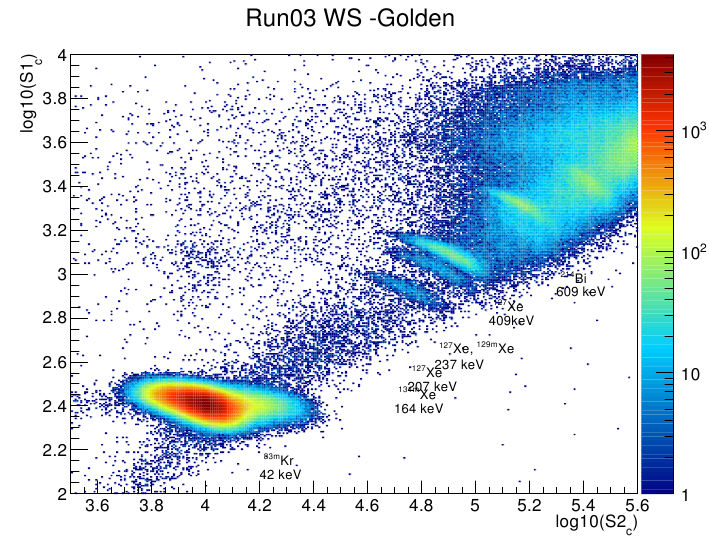

In [110]:
# Make the S2 vs S1 density plot for the WS data

density_plt_hst=TH2F('density_plt_hst','Run03 WS -Golden ;log10(S2_{c});log10(S1_{c})',300,3.5,5.6,300,2,4) #include Kr
#density_plt_hst=TH2F('density_plt_hst','Xe act + Bi214 + Cs ;log10(S2_{c});log10(S1_{c})',200,4.5,5.6,200,2.8,4) #include Kr

chain.Draw('log10(s1area):log10(s2area)>>density_plt_hst',fid_vol+area_cut+bad_area_cut,'colz')
#chain2.Draw('log10(s1area):log10(s2area)>>density_plt_hst2',fid_vol+area_cut+bad_area_cut,"same")
#draw chain2 so see the Cs data. Or load them together in the begining.

#add text for energies in the plot
tt=[]# make an empty list for text files
for ii, xx in enumerate(Energies[1:-1]):
    tt.append(TLatex(cutsx[ii+1][3]-.2,cutsy[ii+1][2]-0.5,NamesE[ii+1]))
    tt[ii].SetTextColor(1)
    tt[ii].SetTextFont(43)
    tt[ii].SetTextSize(20)
    tt[ii].Draw()

c4.SetLogz(1)
gStyle.SetOptStat(0)
gStyle.SetPalette(55)
gStyle.SetNumberContours(100)
c4
#c4.SaveAs('Run03_Golden_Doke/Golden.pdf')

<h1>Loop through all the lines and calcualte the mean S1 and S2 </h1>

In [102]:
jj=7 # start with Kr at 1 (the second entry) and go to 6 (Bi214). Hit the "Run ALL CELLS BELOW" button

In [103]:
E_cut=TCutG("E_cut",4,array(cutsx[jj]),array(cutsy[jj]))
E_cut.SetVarX('log10(s2area)')
E_cut.SetVarY('log10(s1area)')

In [104]:
density_plt_hst=TH2F('density_plt_hst',NamesE[jj]+';log10(S2_{c});log10(S1_{c})',300,3.5,5.6,300,2,4) #include Kr
combined_cut=TCut('E_cut' + '&&'+ fid_vol.GetTitle() + '&&'+ area_cut.GetTitle() + '&&' + bad_area_cut.GetTitle())

if jj==7: #if Cs fit
    n=chain2.Draw('log10(s1area):log10(s2area)>>density_plt_hst',combined_cut,'colz')
else:
    n=chain.Draw('log10(s1area):log10(s2area)>>density_plt_hst',combined_cut,'colz')

TROOT::Append:0: RuntimeWarning: Replacing existing TH1: density_plt_hst (Potential memory leak).


In [105]:
#E_cut.Draw()

In [106]:
c4.SetLogz(0)
gStyle.SetOptStat(0)
gStyle.SetPalette(55)
gStyle.SetNumberContours(50)
c4
c4.SaveAs('Run03_Golden_Doke/{:s}.pdf'.format(NamesE[jj]))

In [107]:
if n>2e5:
    n=2e5

if jj==7: # if Cs data
    s1 = ndarray( (n,),dtype= float64, buffer=chain2.GetV1())
    s2 = ndarray( (n,),dtype= float64, buffer=chain2.GetV2())
else:
    s1 = ndarray( (n,),dtype= float64, buffer=chain.GetV1())
    s2 = ndarray( (n,),dtype= float64, buffer=chain.GetV2())
       
s1=10**s1
s2=10**s2

In [108]:
H, xedges, yedges = histogram2d(s2, s1, bins=20, range=None, normed=False)
H=H.T # need to trasnpose to stay consistent with x,y dimensions. Otherwise flip x and y in histogram2d
x_bin_center=(xedges[:-1]+xedges[1:])/2
y_bin_center=(yedges[:-1]+yedges[1:])/2
#plt.contourf(x_bin_center,y_bin_center,H,20)

In [109]:
initial_guess = (H.max(), mean(s2), mean(s1), std(s2), std(s1),0,0)
x, y = np.meshgrid(x_bin_center, y_bin_center)

popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), H.ravel(), p0=initial_guess)

mean_s2[jj]=popt[1]
mean_s2_sig[jj]=sqrt(pcov[1,1])
mean_s1[jj]=popt[2]
mean_s1_sig[jj]=sqrt(pcov[2,2])

In [110]:
savetxt('Run03_Golden_Doke/fits/{:s}keVfit.txt'.format(NamesE[jj]), popt, fmt='%.18e', delimiter=' ', newline='\n', header='', footer='', comments='# ')
savetxt('Run03_Golden_Doke/fits/{:s}keVcov.txt'.format(NamesE[jj]), pcov, fmt='%.18e', delimiter=' ', newline='\n', header='', footer='', comments='# ')

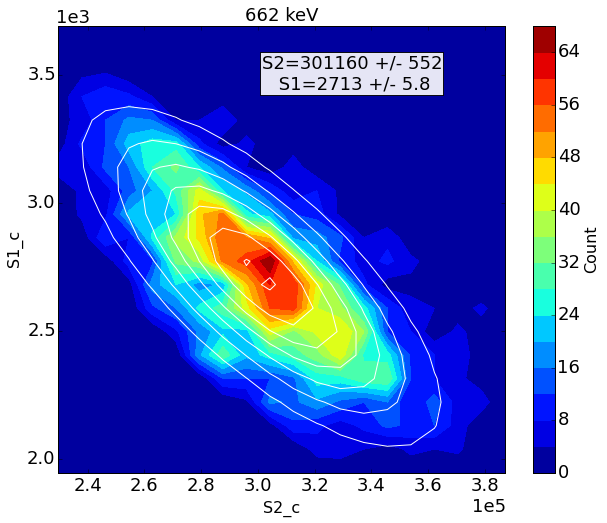

In [111]:
data_fitted = twoD_Gaussian((x, y), *popt)
figure
fig, ax = plt.subplots(1,1)
ax.hold(True)
#ax.imshow(H.reshape(x.shape), cmap=plt.cm.jet, origin='bottom',
#    extent=(x.min(), x.max(), y.min(), y.max()))
plt.contourf(x_bin_center,y_bin_center,H,20)
ax.contour(x, y, data_fitted.reshape(x.shape), 7, colors='w')
plt.xlabel('S2_c',fontsize=16)
plt.ylabel('S1_c',fontsize=16)
#plt.yticks(fontsize=16)
#plt.xticks(fontsize=16)
plt.ticklabel_format(style='sci',axis='both',scilimits=(0,0),fontsize=16)
plt.rcParams.update({'font.size': 18}) #increase all fontsizes

cb=plt.colorbar()
cb.set_label('Count',fontsize=16)
plt.text(x.max()*.86,y.max()*.95,'S2={:1.0f} +/- {:1.0f} \n S1={:1.0f} +/- {:1.1f}'.format(popt[1],sqrt(pcov[1,1]),popt[2],sqrt(pcov[2,2])),
         horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='w', alpha=0.9),fontsize=18)
plt.title('{:s} keV'.format(NamesE[jj]),fontsize=18)
savefig('Run03_Golden_Doke/{:s}_fit.pdf'.format(NamesE[jj]))

<h1> Save means for the Doke plot </h1>

In [213]:
#savetxt('Run03_Golden_Doke/fits/s2_and_s1_means.txt',[mean_s2,mean_s2_sig,mean_s1,mean_s1_sig])